In [1]:
# from model import FeatureExtractor
# import numpy as np
# from data_manager import create_modified_crop_labels, filter_balanced_patches, CropBinaryDataset
# from torch.utils.data import DataLoader
# from model import create_feature_pairs, modified_sigmoid
# import torch.optim as optim
# import torch

In [2]:
# features_extractor = FeatureExtractor(num_block = 3, 
#                         kernel_size = 9, 
#                         stride = 1, 
#                         padding = 4, 
#                         num_channel_in = 18, 
#                         num_channel_internal = 6, 
#                         num_channel_out = 18, 
#                         matrix_size = 18,
#                         device = 'cuda')

# path_to_train_data = './training_data/train_patches.npy'
# path_to_valid_data = './training_data/val_patches.npy'
# path_to_test_data = './training_data/test_patches.npy'

# train_data = np.load(path_to_train_data)
# valid_data = np.load(path_to_valid_data)
# test_data = np.load(path_to_test_data)

# unchanged_crops = [1, 5, 23, 176]

# train_data = create_modified_crop_labels(train_data, unchanged_crops=unchanged_crops, other_value=-1, crop_band_index=18)
# valid_data = create_modified_crop_labels(valid_data, unchanged_crops=unchanged_crops, other_value=-1, crop_band_index=18)
# test_data  = create_modified_crop_labels(test_data,  unchanged_crops=unchanged_crops, other_value=-1, crop_band_index=18)


# target_crops = [5, 23, 176]
# train_batch_size = 8

# filterd_train_data, _ = filter_balanced_patches(train_data, target_crops, ignore_crops=None)
# train_dataset = CropBinaryDataset(filterd_train_data, target_crops=target_crops, crop_band_index=18, device='cuda')
# train_loader = DataLoader(train_dataset, batch_size=train_batch_size)

Filtered 1074 patches to 536 good patches (49.91%)
Dataset loaded with 536 patches
Total pixels: 26894336
Positive pixels (+1): 13105006
Negative pixels (-1): 13789330


In [3]:
# d_star = 1.0
# margin = 5.0
# num_epochs = 4  # or however many epochs you want

# optimizer = optim.Adam(features_extractor.parameters())

# # Training loop
# for epoch in range(num_epochs):
#     print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
#     # Initialize epoch statistics
#     epoch_loss = 0.0
#     num_batches = 0
    
#     # Training loop
#     for batch_idx, (bands, label) in enumerate(train_loader):
#         # Extract features
#         features = features_extractor(bands)
#         features = features.reshape(-1, features.shape[-1])
#         label = label.reshape(-1)
        
#         # Create random pairs
#         pairs, pair_labels = create_feature_pairs(
#             features=features,
#             labels=label,
#             num_pairs=3000
#         )

#         positive_pairs = pair_labels == 1
#         negative_pairs = pair_labels == -1
        
#         distances = ((pairs[:, 0] - pairs[:, 1]) ** 2).sum(dim=1)
#         weights = modified_sigmoid(distances, d_star=d_star)
        
#         sum1 = ((2 - weights[positive_pairs]) * distances[positive_pairs]).mean()
#         sum2 = ((2 + weights[negative_pairs]) * torch.clamp(margin - distances[negative_pairs], min=0)).mean()
#         loss = sum1 + sum2
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         # Update statistics
#         epoch_loss += loss.item()
#         num_batches += 1
        
#         # Print progress every N batches
#         # if (batch_idx + 1) % 10 == 0:  # Adjust this number based on your batch size
#         #     print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
#     # Print epoch statistics
#     avg_epoch_loss = epoch_loss / num_batches
#     print(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")


Epoch 1/4
Epoch 1 completed. Average Loss: 135360.7638

Epoch 2/4
Epoch 2 completed. Average Loss: 13.4167

Epoch 3/4
Epoch 3 completed. Average Loss: 17.0104

Epoch 4/4
Epoch 4 completed. Average Loss: 12.8346


In [7]:
# valid_batch_size = 1

# valid_dataset = CropBinaryDataset(valid_data, target_crops=target_crops, crop_band_index=18, device='cuda')
# valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size)


Dataset loaded with 231 patches
Total pixels: 11590656
Positive pixels (+1): 5498562
Negative pixels (-1): 6092094


In [7]:
from model import FeatureExtractor
import numpy as np
from data_manager import (
    create_modified_crop_labels,
    filter_balanced_patches,
    CropBinaryDataset,
    setup_training_loader,
    setup_validation_loader,
    create_sparse_structure_from_images
)
from torch.utils.data import DataLoader
from model import create_feature_pairs, modified_sigmoid, create_coo_sparse_matrix
import torch.optim as optim
import torch
from tqdm import tqdm
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
from utils import correct_pred_sign

In [8]:
train_loader = setup_training_loader(
    path_to_train_data='./training_data/train_patches.npy',
    unchanged_crops=[1, 5, 23, 176],
    target_crops=[176],
    train_batch_size=16,
    crop_band_index=18,
    device='cuda',
    ignore_crops=None,  # Example: ignore crop ID 1 when filtering balanced patches
    min_ratio=0.1,
    max_ratio=0.9
)

Filtered 1074 patches to 702 good patches (65.36%)
Dataset loaded with 702 patches
Total pixels: 35223552
Positive pixels (+1): 10910374
Negative pixels (-1): 24313178


In [9]:
val_loader = setup_training_loader(
    path_to_train_data='./training_data/val_patches.npy',
    unchanged_crops=[1, 5, 23, 176],
    target_crops=[176],
    train_batch_size=1,
    crop_band_index=18,
    device='cuda',
    ignore_crops=None,  # Example: ignore crop ID 1 when filtering balanced patches
    min_ratio=0.4,
    max_ratio=0.6
)

Filtered 231 patches to 39 good patches (16.88%)
Dataset loaded with 39 patches
Total pixels: 1956864
Positive pixels (+1): 971003
Negative pixels (-1): 985861


In [4]:
features_extractor = FeatureExtractor(num_block = 4, 
                        kernel_size = 9, 
                        stride = 1, 
                        padding = 4, 
                        num_channel_in = 18, 
                        num_channel_internal = 18, 
                        num_channel_out = 18, 
                        matrix_size = 18,
                        device = 'cuda')

# state_dict = torch.load('./checkpoints/176_vs_all.pth', weights_only=True)
# features_extractor.load_state_dict(state_dict)

In [5]:
# Count only trainable parameters
trainable_params = sum(p.numel() for p in features_extractor.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)


Trainable parameters: 262944


In [6]:
optimizer = optim.Adam(features_extractor.parameters(), lr=0.001)

# Reduce the learning rate by a factor of 0.1 every 3 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

In [7]:
d_star = 1.0
margin = 5.0
num_epochs = 1  # or however many epochs you want


features_extractor.train()
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Initialize epoch statistics
    epoch_loss = 0.0
    num_batches = 0
    
    # Training loop
    for batch_idx, (bands, label) in enumerate(tqdm(train_loader)):
        # Extract features
        features = features_extractor(bands)
        features = features.reshape(-1, features.shape[-1])
        label = label.reshape(-1)
        
        # Create random pairs
        pairs, pair_labels = create_feature_pairs(
            features=features,
            labels=label,
            num_pairs=5000
        )

        positive_pairs = pair_labels == 1
        negative_pairs = pair_labels == -1
        
        distances = ((pairs[:, 0] - pairs[:, 1]) ** 2).sum(dim=1)
        weights = modified_sigmoid(distances, d_star=d_star)
        
        sum1 = ((2 - weights[positive_pairs]) * distances[positive_pairs]).mean()
        sum2 = ((2 + weights[negative_pairs]) * torch.clamp(margin - distances[negative_pairs], min=0)).mean()
        loss = sum1 + sum2
        
        # Backward pass
        loss.backward()
        
        # Add gradient clipping here
        torch.nn.utils.clip_grad_norm_(features_extractor.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()
        
        # Update statistics
        epoch_loss += loss.item()
        num_batches += 1
        
        # Print progress every N batches
        # if (batch_idx + 1) % 10 == 0:  # Adjust this number based on your batch size
        #     print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    scheduler.step()
    # Print epoch statistics
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")


Epoch 1/1


100%|████████████████████████████████████████████████████████| 44/44 [04:37<00:00,  6.31s/it]

Epoch 1 completed. Average Loss: 10.4266


In [8]:
positive_center, negative_center = features_extractor.calculate_feature_centers(train_loader)

In [2]:
img_height = img_width = 112
window_size = 30
device = 'cuda'
sparse_image_obj = create_sparse_structure_from_images(img_height, img_width, window_size, device)
order = sparse_image_obj['order']
edges = sparse_image_obj['edges']
edges = edges.cpu().numpy()
edge_i, edge_j = edges[:, 0], edges[:, 1]

In [37]:
# valid_accuracy_list = []
# valid_f1_score_list = []

# with torch.no_grad():
    
#     features_extractor.eval()
#     for bands, label in tqdm(val_loader):
#         features = features_extractor(bands).squeeze(0)
#         features = features[:112, :112, :]
#         features = features.reshape(-1, features.shape[-1])[order, :]        
#         label = label.squeeze(0)[:112,:112].reshape(-1)[order]
#         # features = features_extractor(bands).squeeze(0)
#         # features = features.reshape(-1, features.shape[-1])[order, :]
#         # label = label.squeeze(0).reshape(-1)[order]

        
#         features_i, features_j = features[edge_i], features[edge_j]
#         distances = ((features_i - features_j) ** 2).sum(dim=1)
#         weights = modified_sigmoid(distances, d_star, scale=1)

#         coo_mat = create_coo_sparse_matrix(edges, weights.cpu().numpy())
#         sparse_adjacency = coo_mat + coo_mat.T

#         degree = sparse_adjacency.sum(axis=1).A1  # Compute degree vector
#         D = diags(degree)                         # Degree matrix
#         L = D - sparse_adjacency 

#         _, eigen_vector = eigsh(L, k=1, which='SA', tol=1e-7)
#         pred = np.sign(eigen_vector).flatten()
#         pred = correct_pred_sign(pred, features, positive_center, negative_center)
        
#         y = label.cpu().numpy()
        
#         # valid_accuracy_list.append(max(np.sum(y == -1 * pred) / len(pred),
#         #            np.sum(y == pred) / len(pred)))

#         valid_accuracy_list.append(np.sum(y == pred) / len(pred))
#         valid_f1_score_list.append(f1_score(y, pred, pos_label=1))

#         print(valid_accuracy_list[-1])
#         print(valid_f1_score_list[-1])


# print(np.mean(valid_accuracy_list))
# print(np.mean(valid_f1_score_list))

  1%|▌                                                       | 1/103 [00:01<02:09,  1.27s/it]

0.8919802295918368
0.8441991491318845


  2%|█                                                       | 2/103 [00:02<01:49,  1.08s/it]

0.9293686224489796
0.9132563148619541


  3%|█▋                                                      | 3/103 [00:03<01:51,  1.12s/it]

0.9357461734693877
0.8761524277811924


  4%|██▏                                                     | 4/103 [00:04<01:49,  1.11s/it]

0.8698979591836735
0.7575037147102526


  5%|██▋                                                     | 5/103 [00:05<01:57,  1.20s/it]

0.9112723214285714
0.8172713840091939


  6%|███▎                                                    | 6/103 [00:06<01:44,  1.08s/it]

0.9324776785714286
0.9376701744057694


  7%|███▊                                                    | 7/103 [00:07<01:39,  1.04s/it]

0.9359853316326531
0.8852365299414034


  8%|████▎                                                   | 8/103 [00:08<01:35,  1.01s/it]

0.9196428571428571
0.9058119977574285


  9%|████▉                                                   | 9/103 [00:09<01:36,  1.02s/it]

0.9198820153061225
0.8801431127012522


 10%|█████▎                                                 | 10/103 [00:10<01:44,  1.13s/it]

0.9142219387755102
0.8089488636363636


 11%|█████▊                                                 | 11/103 [00:12<01:41,  1.10s/it]

0.8741230867346939
0.8972339733159779


 12%|██████▍                                                | 12/103 [00:13<01:39,  1.09s/it]

0.8840082908163265
0.859243494243978


 13%|██████▉                                                | 13/103 [00:14<01:36,  1.08s/it]

0.8081951530612245
0.7835552356962936


 14%|███████▍                                               | 14/103 [00:15<01:40,  1.13s/it]

0.7119738520408163
0.07430181911350243


 15%|████████                                               | 15/103 [00:16<01:34,  1.08s/it]

0.9093590561224489
0.9025790420700882


 16%|████████▌                                              | 16/103 [00:17<01:27,  1.01s/it]

0.8972417091836735
0.8912144484766646


 17%|█████████                                              | 17/103 [00:18<01:28,  1.03s/it]

0.9256218112244898
0.8109422492401216


 17%|█████████▌                                             | 18/103 [00:19<01:28,  1.04s/it]

0.9555165816326531
0.7625531914893617


 18%|██████████▏                                            | 19/103 [00:20<01:27,  1.04s/it]

0.9294483418367347
0.9180783115801167


 19%|██████████▋                                            | 20/103 [00:21<01:31,  1.11s/it]

0.6103316326530612
0.3568421052631579


 20%|███████████▏                                           | 21/103 [00:22<01:34,  1.15s/it]

0.6503507653061225
0.49759450171821307


 21%|███████████▋                                           | 22/103 [00:24<01:33,  1.15s/it]

0.9169323979591837
0.9328088728398246


 22%|████████████▎                                          | 23/103 [00:25<01:32,  1.15s/it]

0.8501275510204082
0.6739507457509538


 23%|████████████▊                                          | 24/103 [00:26<01:31,  1.16s/it]

0.8952487244897959
0.9106122448979592


 24%|█████████████▎                                         | 25/103 [00:27<01:25,  1.10s/it]

0.9312021683673469
0.9256995264743866


 25%|█████████████▉                                         | 26/103 [00:28<01:21,  1.05s/it]

0.8524394132653061
0.8143616487814662


 26%|██████████████▍                                        | 27/103 [00:29<01:22,  1.08s/it]

0.9635682397959183
0.729745712596097


 27%|██████████████▉                                        | 28/103 [00:30<01:22,  1.10s/it]

0.8986766581632653
0.8920777787212363


 28%|███████████████▍                                       | 29/103 [00:31<01:25,  1.16s/it]

0.9030612244897959
0.9238476953907816


 29%|████████████████                                       | 30/103 [00:32<01:19,  1.10s/it]

0.6913265306122449
0.4152823920265781


 30%|████████████████▌                                      | 31/103 [00:33<01:17,  1.08s/it]

0.9381377551020408
0.9053889295293831


 31%|█████████████████                                      | 32/103 [00:34<01:16,  1.07s/it]

0.8957270408163265
0.7423167848699763


 32%|█████████████████▌                                     | 33/103 [00:36<01:16,  1.09s/it]

0.9655612244897959
0.8454935622317596


 33%|██████████████████▏                                    | 34/103 [00:37<01:16,  1.11s/it]

0.7626753826530612
0.49448123620309054


 34%|██████████████████▋                                    | 35/103 [00:38<01:14,  1.09s/it]

0.919563137755102
0.912648255562289


 35%|███████████████████▏                                   | 36/103 [00:39<01:08,  1.02s/it]

0.9420440051020408
0.8673599708082467


 36%|███████████████████▊                                   | 37/103 [00:40<01:12,  1.10s/it]

0.9541613520408163
0.7434181169120928


 37%|████████████████████▎                                  | 38/103 [00:41<01:10,  1.08s/it]

0.9088010204081632
0.9046348782927642


 38%|████████████████████▊                                  | 39/103 [00:42<01:08,  1.07s/it]

0.9704241071428571
0.4979702300405954


 39%|█████████████████████▎                                 | 40/103 [00:43<01:13,  1.16s/it]

0.9182876275510204
0.8845850692489584


 40%|█████████████████████▉                                 | 41/103 [00:44<01:08,  1.10s/it]

0.8884725765306123
0.8716160411122327


 41%|██████████████████████▍                                | 42/103 [00:45<01:08,  1.12s/it]

0.9336734693877551
0.6498316498316499


 42%|██████████████████████▉                                | 43/103 [00:47<01:05,  1.10s/it]

0.9216358418367347
0.8611385788953242


 43%|███████████████████████▍                               | 44/103 [00:48<01:03,  1.08s/it]

0.9437978316326531
0.8082676094642371


 44%|████████████████████████                               | 45/103 [00:49<01:03,  1.10s/it]

0.9147799744897959
0.7478178815758434


 45%|████████████████████████▌                              | 46/103 [00:50<01:05,  1.15s/it]

0.9513711734693877
0.8589921405455386


 46%|█████████████████████████                              | 47/103 [00:51<01:00,  1.09s/it]

0.9325573979591837
0.8825


 47%|█████████████████████████▋                             | 48/103 [00:52<00:55,  1.02s/it]

0.8879942602040817
0.7688764599440697


 48%|██████████████████████████▏                            | 49/103 [00:53<00:59,  1.10s/it]

0.8857621173469388
0.8581890153389411


 49%|██████████████████████████▋                            | 50/103 [00:55<01:03,  1.21s/it]

0.9485809948979592
0.9608259945338598


 50%|███████████████████████████▏                           | 51/103 [00:56<01:03,  1.22s/it]

0.9369419642857143
0.8417050230138083


 50%|███████████████████████████▊                           | 52/103 [00:57<00:59,  1.17s/it]

0.9181281887755102
0.7927346115035317


 51%|████████████████████████████▎                          | 53/103 [00:58<01:01,  1.23s/it]

0.8369738520408163
0.6034516191584255


 52%|████████████████████████████▊                          | 54/103 [00:59<00:59,  1.21s/it]

0.9599011479591837
0.7575903614457832


 53%|█████████████████████████████▎                         | 55/103 [01:00<00:54,  1.13s/it]

0.920280612244898
0.9300699300699301


 54%|█████████████████████████████▉                         | 56/103 [01:01<00:53,  1.14s/it]

0.947624362244898
0.7017703132092601


 55%|██████████████████████████████▍                        | 57/103 [01:03<00:51,  1.11s/it]

0.9305644132653061
0.9348492781808662


 56%|██████████████████████████████▉                        | 58/103 [01:04<00:49,  1.09s/it]

0.9249043367346939
0.7467741935483871


 57%|███████████████████████████████▌                       | 59/103 [01:05<00:47,  1.08s/it]

0.9685905612244898
0.55125284738041


 58%|████████████████████████████████                       | 60/103 [01:06<00:48,  1.13s/it]

0.9079241071428571
0.6695278969957081


 59%|████████████████████████████████▌                      | 61/103 [01:07<00:46,  1.12s/it]

0.4945790816326531
0.21124657875093306


 60%|█████████████████████████████████                      | 62/103 [01:08<00:46,  1.13s/it]

0.9049744897959183
0.848730964467005


 61%|█████████████████████████████████▋                     | 63/103 [01:09<00:42,  1.07s/it]

0.9174107142857143
0.8748792270531401


 62%|██████████████████████████████████▏                    | 64/103 [01:10<00:40,  1.03s/it]

0.8772321428571429
0.7006220839813375


 63%|██████████████████████████████████▋                    | 65/103 [01:11<00:42,  1.11s/it]

0.6565688775510204
0.30403877221324715


 64%|███████████████████████████████████▏                   | 66/103 [01:12<00:40,  1.10s/it]

0.91015625
0.8722656692734897


 65%|███████████████████████████████████▊                   | 67/103 [01:13<00:38,  1.08s/it]

0.9068080357142857
0.8711845730027549


 66%|████████████████████████████████████▎                  | 68/103 [01:14<00:35,  1.01s/it]

0.9244260204081632
0.8375599725839616


 67%|████████████████████████████████████▊                  | 69/103 [01:15<00:35,  1.05s/it]

0.9009088010204082
0.8865772424491286


 68%|█████████████████████████████████████▍                 | 70/103 [01:17<00:36,  1.11s/it]

0.8736447704081632
0.8854023570240763


 69%|█████████████████████████████████████▉                 | 71/103 [01:18<00:38,  1.19s/it]

0.9300063775510204
0.9178364214860565


 70%|██████████████████████████████████████▍                | 72/103 [01:19<00:36,  1.18s/it]

0.9186065051020408
0.8268023748939779


 71%|██████████████████████████████████████▉                | 73/103 [01:20<00:33,  1.12s/it]

0.5031090561224489
0.0904713264263826


 72%|███████████████████████████████████████▌               | 74/103 [01:21<00:32,  1.13s/it]

0.8841677295918368
0.7493531136794894


 73%|████████████████████████████████████████               | 75/103 [01:22<00:30,  1.07s/it]

0.8237404336734694
0.8233320015980823


 74%|████████████████████████████████████████▌              | 76/103 [01:24<00:30,  1.13s/it]

0.8487723214285714
0.8625661088169239


 75%|█████████████████████████████████████████              | 77/103 [01:25<00:30,  1.18s/it]

0.8853635204081632
0.6449382716049382


 76%|█████████████████████████████████████████▋             | 78/103 [01:26<00:26,  1.08s/it]

0.9022640306122449
0.8842959607399018


 77%|██████████████████████████████████████████▏            | 79/103 [01:27<00:25,  1.07s/it]

0.9507334183673469
0.8506524891251812


 78%|██████████████████████████████████████████▋            | 80/103 [01:28<00:24,  1.06s/it]

0.7691326530612245
0.8259615384615384


 79%|███████████████████████████████████████████▎           | 81/103 [01:29<00:23,  1.09s/it]

0.8014190051020408
0.683602184681824


 80%|███████████████████████████████████████████▊           | 82/103 [01:30<00:23,  1.11s/it]

0.8992346938775511
0.8854657484595868


 81%|████████████████████████████████████████████▎          | 83/103 [01:31<00:23,  1.15s/it]

0.9135044642857143
0.8205721845543245


 82%|████████████████████████████████████████████▊          | 84/103 [01:33<00:22,  1.19s/it]

0.9332748724489796
0.9290738073044658


 83%|█████████████████████████████████████████████▍         | 85/103 [01:34<00:20,  1.16s/it]

0.9347098214285714
0.9424495818986719


 83%|█████████████████████████████████████████████▉         | 86/103 [01:35<00:19,  1.12s/it]

0.6746651785714286
0.5596201575482896


 84%|██████████████████████████████████████████████▍        | 87/103 [01:36<00:17,  1.10s/it]

0.8559470663265306
0.82386197485135


 85%|██████████████████████████████████████████████▉        | 88/103 [01:37<00:17,  1.15s/it]

0.9373405612244898
0.9305776364599894


 86%|███████████████████████████████████████████████▌       | 89/103 [01:38<00:15,  1.10s/it]

0.8470184948979592
0.7031709203402939


 87%|████████████████████████████████████████████████       | 90/103 [01:39<00:14,  1.08s/it]

0.9211575255102041
0.8686063504716355


 88%|████████████████████████████████████████████████▌      | 91/103 [01:40<00:13,  1.10s/it]

0.45487882653061223
0.30592773041006904


 89%|█████████████████████████████████████████████████▏     | 92/103 [01:41<00:12,  1.12s/it]

0.818000637755102
0.8572143348552129


 90%|█████████████████████████████████████████████████▋     | 93/103 [01:42<00:11,  1.13s/it]

0.8859215561224489
0.8835733463509885


 91%|██████████████████████████████████████████████████▏    | 94/103 [01:44<00:10,  1.14s/it]

0.9520886479591837
0.6703236423477784


 92%|██████████████████████████████████████████████████▋    | 95/103 [01:45<00:08,  1.08s/it]

0.8486926020408163
0.8376667807047554


 93%|███████████████████████████████████████████████████▎   | 96/103 [01:46<00:08,  1.16s/it]

0.5554846938775511
0.055235513385293124


 94%|███████████████████████████████████████████████████▊   | 97/103 [01:47<00:07,  1.23s/it]

0.9043367346938775
0.8704383502483265


 95%|████████████████████████████████████████████████████▎  | 98/103 [01:49<00:06,  1.21s/it]

0.5604272959183674
0.33821411425828135


 96%|████████████████████████████████████████████████████▊  | 99/103 [01:50<00:05,  1.26s/it]

0.9345503826530612
0.9451386568660207


 97%|████████████████████████████████████████████████████▍ | 100/103 [01:51<00:03,  1.16s/it]

0.9311224489795918
0.9124620060790274


 98%|████████████████████████████████████████████████████▉ | 101/103 [01:52<00:02,  1.14s/it]

0.9245057397959183
0.6619064619778651


 99%|█████████████████████████████████████████████████████▍| 102/103 [01:53<00:01,  1.21s/it]

0.9215561224489796
0.4252336448598131


100%|██████████████████████████████████████████████████████| 103/103 [01:54<00:00,  1.11s/it]

0.9209980867346939
0.934772592641348
0.8734806877848227
0.7651322515267687


In [20]:
valid_accuracy_list = []
valid_f1_score_list = []

with torch.no_grad():
    features_extractor.eval()
    for bands, label in tqdm(val_loader):
        # Get the full features
        features = features_extractor(bands).squeeze(0)
        
        # Process each 112x112 quadrant
        for i in range(2):
            for j in range(2):
                # Extract the 112x112 quadrant
                start_h = i * 112
                start_w = j * 112
                quadrant_features = features[start_h:start_h+112, start_w:start_w+112, :]
                quadrant_label = label.squeeze(0)[start_h:start_h+112, start_w:start_w+112]
                
                # Reshape and reorder
                quadrant_features = quadrant_features.reshape(-1, quadrant_features.shape[-1])[order, :]
                quadrant_label = quadrant_label.reshape(-1)[order]
                
                # Calculate distances and weights
                features_i, features_j = quadrant_features[edge_i], quadrant_features[edge_j]
                distances = ((features_i - features_j) ** 2).sum(dim=1)
                weights = modified_sigmoid(distances, d_star, scale=1)
                
                # Create sparse matrix and compute Laplacian
                coo_mat = create_coo_sparse_matrix(edges, weights.cpu().numpy())
                sparse_adjacency = coo_mat + coo_mat.T
                
                degree = sparse_adjacency.sum(axis=1).A1
                D = diags(degree)
                L = D - sparse_adjacency
                
                # Compute eigenvector and prediction
                _, eigen_vector = eigsh(L, k=1, which='SA', tol=1e-7)
                pred = np.sign(eigen_vector).flatten()
                pred = correct_pred_sign(pred, quadrant_features, positive_center, negative_center)
                y = quadrant_label.cpu().numpy()

                valid_accuracy_list.append(np.sum(y == pred) / len(pred))
                valid_f1_score_list.append(f1_score(y, pred, pos_label=1))

                print(f"Quadrant ({i},{j}) accuracy: {valid_accuracy_list[-1]} f1_score: {valid_f1_score_list[-1]}")
        
print(f"Mean validation accuracy across all quadrants: {np.mean(valid_accuracy_list)}")
print(f"Mean validation accuracy across all quadrants: {np.mean(valid_f1_score_list)}")

  0%|                                     | 0/39 [00:00<?, ?it/s]

Quadrant (0,0) accuracy: 0.5518973214285714 f1_score: 0.6875660052248347
Quadrant (0,1) accuracy: 0.7136479591836735 f1_score: 0.8133444190397007
Quadrant (1,0) accuracy: 0.5305325255102041 f1_score: 0.6654167376853588


  3%|▋                            | 1/39 [00:04<02:44,  4.32s/it]

Quadrant (1,1) accuracy: 0.5935905612244898 f1_score: 0.7226936466492603
Quadrant (0,0) accuracy: 0.5153061224489796 f1_score: 0.6244131455399061
Quadrant (0,1) accuracy: 0.5463966836734694 f1_score: 0.6931952981775046
Quadrant (1,0) accuracy: 0.5201690051020408 f1_score: 0.4997090848641011


  5%|█▍                           | 2/39 [00:09<02:48,  4.56s/it]

Quadrant (1,1) accuracy: 0.5719866071428571 f1_score: 0.6255666364460563
Quadrant (0,0) accuracy: 0.4216358418367347 f1_score: 0.540095087163233
Quadrant (0,1) accuracy: 0.5052614795918368 f1_score: 0.6420166128287955
Quadrant (1,0) accuracy: 0.6233258928571429 f1_score: 0.7173535921517019


  8%|██▏                          | 3/39 [00:13<02:42,  4.51s/it]

Quadrant (1,1) accuracy: 0.6300223214285714 f1_score: 0.7303782025213501
Quadrant (0,0) accuracy: 0.6052295918367347 f1_score: 0.7207308820212046
Quadrant (0,1) accuracy: 0.6631855867346939 f1_score: 0.7676656585097608
Quadrant (1,0) accuracy: 0.4658801020408163 f1_score: 0.5488823054134123


 10%|██▉                          | 4/39 [00:18<02:38,  4.54s/it]

Quadrant (1,1) accuracy: 0.5248724489795918 f1_score: 0.6047221116859
Quadrant (0,0) accuracy: 0.7660235969387755 f1_score: 0.8125678523532792
Quadrant (0,1) accuracy: 0.7464923469387755 f1_score: 0.7872340425531915
Quadrant (1,0) accuracy: 0.7823660714285714 f1_score: 0.8338607594936709


 13%|███▋                         | 5/39 [00:22<02:28,  4.38s/it]

Quadrant (1,1) accuracy: 0.7712850765306123 f1_score: 0.8113864966142923
Quadrant (0,0) accuracy: 0.7378029336734694 f1_score: 0.7139751282720237
Quadrant (0,1) accuracy: 0.7880261479591837 f1_score: 0.7263558711536482
Quadrant (1,0) accuracy: 0.7708067602040817 f1_score: 0.7484469332400036


 15%|████▍                        | 6/39 [00:26<02:23,  4.35s/it]

Quadrant (1,1) accuracy: 0.6650191326530612 f1_score: 0.7356567689984902
Quadrant (0,0) accuracy: 0.6878985969387755 f1_score: 0.7140039447731755
Quadrant (0,1) accuracy: 0.5498246173469388 f1_score: 0.4129327372907787
Quadrant (1,0) accuracy: 0.7532684948979592 f1_score: 0.8048426760829813


 18%|█████▏                       | 7/39 [00:30<02:17,  4.29s/it]

Quadrant (1,1) accuracy: 0.6842315051020408 f1_score: 0.6972869698127627
Quadrant (0,0) accuracy: 0.5672034438775511 f1_score: 0.6797239100937997
Quadrant (0,1) accuracy: 0.7588488520408163 f1_score: 0.7393364928909952
Quadrant (1,0) accuracy: 0.5000797193877551 f1_score: 0.6208814461036213


 21%|█████▉                       | 8/39 [00:34<02:13,  4.30s/it]

Quadrant (1,1) accuracy: 0.7737563775510204 f1_score: 0.8657902203726473
Quadrant (0,0) accuracy: 0.5690369897959183 f1_score: 0.6940230925967852
Quadrant (0,1) accuracy: 0.673469387755102 f1_score: 0.7081373806470002
Quadrant (1,0) accuracy: 0.4694674744897959 f1_score: 0.5700071073205402


 23%|██████▋                      | 9/39 [00:39<02:13,  4.46s/it]

Quadrant (1,1) accuracy: 0.5549266581632653 f1_score: 0.6852342560748718
Quadrant (0,0) accuracy: 0.4338329081632653 f1_score: 0.5645616186388719
Quadrant (0,1) accuracy: 0.5384247448979592 f1_score: 0.6774732620320856
Quadrant (1,0) accuracy: 0.5082908163265306 f1_score: 0.5558755760368663


 26%|███████▏                    | 10/39 [00:44<02:10,  4.51s/it]

Quadrant (1,1) accuracy: 0.5577965561224489 f1_score: 0.704112658025284
Quadrant (0,0) accuracy: 0.7315051020408163 f1_score: 0.7567528528094757
Quadrant (0,1) accuracy: 0.7506377551020408 f1_score: 0.8009924926835476
Quadrant (1,0) accuracy: 0.7684151785714286 f1_score: 0.6652840188961862


 28%|███████▉                    | 11/39 [00:48<02:05,  4.48s/it]

Quadrant (1,1) accuracy: 0.7458545918367347 f1_score: 0.7039925719591458
Quadrant (0,0) accuracy: 0.8100286989795918 f1_score: 0.8429447044091478
Quadrant (0,1) accuracy: 0.7340561224489796 f1_score: 0.7679465776293823
Quadrant (1,0) accuracy: 0.4955357142857143 f1_score: 0.49561613263191456


 31%|████████▌                   | 12/39 [00:53<02:00,  4.45s/it]

Quadrant (1,1) accuracy: 0.6414221938775511 f1_score: 0.7469052442043664
Quadrant (0,0) accuracy: 0.5402582908163265 f1_score: 0.6462180234341451
Quadrant (0,1) accuracy: 0.6214126275510204 f1_score: 0.5727395411605938
Quadrant (1,0) accuracy: 0.6971460459183674 f1_score: 0.8123857968294731


 33%|█████████▎                  | 13/39 [00:57<01:55,  4.43s/it]

Quadrant (1,1) accuracy: 0.7729591836734694 f1_score: 0.7974683544303798
Quadrant (0,0) accuracy: 0.7631536989795918 f1_score: 0.8304514067225932
Quadrant (0,1) accuracy: 0.8167251275510204 f1_score: 0.7257545031611595
Quadrant (1,0) accuracy: 0.7367665816326531 f1_score: 0.7537291169451074


 36%|██████████                  | 14/39 [01:01<01:46,  4.27s/it]

Quadrant (1,1) accuracy: 0.6096141581632653 f1_score: 0.4842548709847288
Quadrant (0,0) accuracy: 0.5420121173469388 f1_score: 0.6479563698756051
Quadrant (0,1) accuracy: 0.6464445153061225 f1_score: 0.7649085608269282
Quadrant (1,0) accuracy: 0.5807557397959183 f1_score: 0.7121983253981284


 38%|██████████▊                 | 15/39 [01:05<01:43,  4.29s/it]

Quadrant (1,1) accuracy: 0.5790816326530612 f1_score: 0.4478142647981594
Quadrant (0,0) accuracy: 0.6702008928571429 f1_score: 0.7723044746546315
Quadrant (0,1) accuracy: 0.6326530612244898 f1_score: 0.7385976855003403
Quadrant (1,0) accuracy: 0.6002072704081632 f1_score: 0.7126568498252449


 41%|███████████▍                | 16/39 [01:10<01:42,  4.46s/it]

Quadrant (1,1) accuracy: 0.6796875 f1_score: 0.7745736086175943
Quadrant (0,0) accuracy: 0.5800382653061225 f1_score: 0.6868014268727705
Quadrant (0,1) accuracy: 0.6501116071428571 f1_score: 0.6500279084602504
Quadrant (1,0) accuracy: 0.6292251275510204 f1_score: 0.6755946153309619


 44%|████████████▏               | 17/39 [01:15<01:38,  4.48s/it]

Quadrant (1,1) accuracy: 0.6454081632653061 f1_score: 0.7235550031075202
Quadrant (0,0) accuracy: 0.6169483418367347 f1_score: 0.7030100747883058
Quadrant (0,1) accuracy: 0.5900829081632653 f1_score: 0.6719407936710476
Quadrant (1,0) accuracy: 0.5760522959183674 f1_score: 0.7099694589877836


 46%|████████████▉               | 18/39 [01:19<01:35,  4.57s/it]

Quadrant (1,1) accuracy: 0.4534438775510204 f1_score: 0.49267426372650586
Quadrant (0,0) accuracy: 0.6438934948979592 f1_score: 0.7601610738255034
Quadrant (0,1) accuracy: 0.6419005102040817 f1_score: 0.6827235485238028
Quadrant (1,0) accuracy: 0.5263073979591837 f1_score: 0.6650884905873069


 49%|█████████████▋              | 19/39 [01:24<01:30,  4.53s/it]

Quadrant (1,1) accuracy: 0.4616549744897959 f1_score: 0.48485773132962084
Quadrant (0,0) accuracy: 0.5253507653061225 f1_score: 0.5432648051549555
Quadrant (0,1) accuracy: 0.6529815051020408 f1_score: 0.7710032090062602
Quadrant (1,0) accuracy: 0.6463647959183674 f1_score: 0.768427646690332


 51%|██████████████▎             | 20/39 [01:28<01:21,  4.31s/it]

Quadrant (1,1) accuracy: 0.596061862244898 f1_score: 0.70342405618964
Quadrant (0,0) accuracy: 0.6807238520408163 f1_score: 0.7628634022144591
Quadrant (0,1) accuracy: 0.7113360969387755 f1_score: 0.7807713265120785
Quadrant (1,0) accuracy: 0.6616709183673469 f1_score: 0.6209360485887817


 54%|███████████████             | 21/39 [01:32<01:18,  4.35s/it]

Quadrant (1,1) accuracy: 0.6643016581632653 f1_score: 0.7349071451054454
Quadrant (0,0) accuracy: 0.6732302295918368 f1_score: 0.7386341898871389
Quadrant (0,1) accuracy: 0.7283163265306123 f1_score: 0.6067389799215325
Quadrant (1,0) accuracy: 0.7781409438775511 f1_score: 0.7453097831060675


 56%|███████████████▊            | 22/39 [01:37<01:14,  4.40s/it]

Quadrant (1,1) accuracy: 0.6192602040816326 f1_score: 0.7159172019985724
Quadrant (0,0) accuracy: 0.6419802295918368 f1_score: 0.6121426720787633
Quadrant (0,1) accuracy: 0.603874362244898 f1_score: 0.6790673642059033
Quadrant (1,0) accuracy: 0.6118463010204082 f1_score: 0.679692125518058


 59%|████████████████▌           | 23/39 [01:41<01:08,  4.25s/it]

Quadrant (1,1) accuracy: 0.5497448979591837 f1_score: 0.6348118453381612
Quadrant (0,0) accuracy: 0.6173469387755102 f1_score: 0.7135012534320162
Quadrant (0,1) accuracy: 0.5832270408163265 f1_score: 0.666751657317695
Quadrant (1,0) accuracy: 0.6536192602040817 f1_score: 0.6876123373355382


 62%|█████████████████▏          | 24/39 [01:44<01:02,  4.16s/it]

Quadrant (1,1) accuracy: 0.6165497448979592 f1_score: 0.6718515486423796
Quadrant (0,0) accuracy: 0.5642538265306123 f1_score: 0.6225659439303963
Quadrant (0,1) accuracy: 0.38966836734693877 f1_score: 0.4703196347031963
Quadrant (1,0) accuracy: 0.7488839285714286 f1_score: 0.6946490887941063


 64%|█████████████████▉          | 25/39 [01:49<00:59,  4.23s/it]

Quadrant (1,1) accuracy: 0.7221779336734694 f1_score: 0.8122204860175656
Quadrant (0,0) accuracy: 0.6353635204081632 f1_score: 0.7354540196645459
Quadrant (0,1) accuracy: 0.5582748724489796 f1_score: 0.662401754706635
Quadrant (1,0) accuracy: 0.8826530612244898 f1_score: 0.7264957264957265


 67%|██████████████████▋         | 26/39 [01:53<00:53,  4.14s/it]

Quadrant (1,1) accuracy: 0.7853156887755102 f1_score: 0.7966472853583025
Quadrant (0,0) accuracy: 0.5955835459183674 f1_score: 0.6147186147186147
Quadrant (0,1) accuracy: 0.5975765306122449 f1_score: 0.6639147802929427
Quadrant (1,0) accuracy: 0.6906887755102041 f1_score: 0.8029856809180461


 69%|███████████████████▍        | 27/39 [01:57<00:51,  4.26s/it]

Quadrant (1,1) accuracy: 0.6777742346938775 f1_score: 0.7829682130584192
Quadrant (0,0) accuracy: 0.5853794642857143 f1_score: 0.6655950620459076
Quadrant (0,1) accuracy: 0.6902104591836735 f1_score: 0.7173818181818182
Quadrant (1,0) accuracy: 0.4971301020408163 f1_score: 0.6110014800197336


 72%|████████████████████        | 28/39 [02:02<00:46,  4.24s/it]

Quadrant (1,1) accuracy: 0.6690848214285714 f1_score: 0.7066638400113067
Quadrant (0,0) accuracy: 0.6375159438775511 f1_score: 0.7527863861251564
Quadrant (0,1) accuracy: 0.7035235969387755 f1_score: 0.7868890034955017
Quadrant (1,0) accuracy: 0.6453284438775511 f1_score: 0.738278722277781


 74%|████████████████████▊       | 29/39 [02:06<00:42,  4.27s/it]

Quadrant (1,1) accuracy: 0.5625797193877551 f1_score: 0.6394164421370835
Quadrant (0,0) accuracy: 0.7113360969387755 f1_score: 0.8010767455913861
Quadrant (0,1) accuracy: 0.5717474489795918 f1_score: 0.7046728971962617
Quadrant (1,0) accuracy: 0.6279496173469388 f1_score: 0.7192781954887218


 77%|█████████████████████▌      | 30/39 [02:10<00:38,  4.26s/it]

Quadrant (1,1) accuracy: 0.6587213010204082 f1_score: 0.7815927758787817
Quadrant (0,0) accuracy: 0.5087691326530612 f1_score: 0.6190652818991098
Quadrant (0,1) accuracy: 0.6512276785714286 f1_score: 0.7660803079719831
Quadrant (1,0) accuracy: 0.5880102040816326 f1_score: 0.7158878504672898


 79%|██████████████████████▎     | 31/39 [02:15<00:34,  4.35s/it]

Quadrant (1,1) accuracy: 0.6978635204081632 f1_score: 0.7987468139337298
Quadrant (0,0) accuracy: 0.6469228316326531 f1_score: 0.743914426134721
Quadrant (0,1) accuracy: 0.6537786989795918 f1_score: 0.7432152781883758
Quadrant (1,0) accuracy: 0.7169164540816326 f1_score: 0.782932942111376


 82%|██████████████████████▉     | 32/39 [02:19<00:30,  4.40s/it]

Quadrant (1,1) accuracy: 0.6124043367346939 f1_score: 0.7113854921049507
Quadrant (0,0) accuracy: 0.7051977040816326 f1_score: 0.7333813987022351
Quadrant (0,1) accuracy: 0.7053571428571429 f1_score: 0.655929994414448
Quadrant (1,0) accuracy: 0.7130899234693877 f1_score: 0.8059942860223168


 85%|███████████████████████▋    | 33/39 [02:23<00:25,  4.30s/it]

Quadrant (1,1) accuracy: 0.7571747448979592 f1_score: 0.8396842105263158
Quadrant (0,0) accuracy: 0.5575573979591837 f1_score: 0.5954220731885115
Quadrant (0,1) accuracy: 0.6356026785714286 f1_score: 0.7269251448712587
Quadrant (1,0) accuracy: 0.5968590561224489 f1_score: 0.6294966664224485


 87%|████████████████████████▍   | 34/39 [02:28<00:21,  4.40s/it]

Quadrant (1,1) accuracy: 0.5709502551020408 f1_score: 0.6946209714026328
Quadrant (0,0) accuracy: 0.759406887755102 f1_score: 0.6815783920658367
Quadrant (0,1) accuracy: 0.7605229591836735 f1_score: 0.8537060485049187
Quadrant (1,0) accuracy: 0.7993463010204082 f1_score: 0.45765998707175176


 90%|█████████████████████████▏  | 35/39 [02:33<00:18,  4.59s/it]

Quadrant (1,1) accuracy: 0.6972257653061225 f1_score: 0.7875125881168177
Quadrant (0,0) accuracy: 0.6919642857142857 f1_score: 0.7996889580093313
Quadrant (0,1) accuracy: 0.6434151785714286 f1_score: 0.6836409929980903
Quadrant (1,0) accuracy: 0.5531728316326531 f1_score: 0.6994799206476865


 92%|█████████████████████████▊  | 36/39 [02:38<00:13,  4.61s/it]

Quadrant (1,1) accuracy: 0.5590720663265306 f1_score: 0.6570347863830843
Quadrant (0,0) accuracy: 0.5453603316326531 f1_score: 0.6365432413485438
Quadrant (0,1) accuracy: 0.525031887755102 f1_score: 0.6244326777609682
Quadrant (1,0) accuracy: 0.6931600765306123 f1_score: 0.7949278064894241


 95%|██████████████████████████▌ | 37/39 [02:42<00:08,  4.46s/it]

Quadrant (1,1) accuracy: 0.49449936224489793 f1_score: 0.621590976905174
Quadrant (0,0) accuracy: 0.6701211734693877 f1_score: 0.7900131939510809
Quadrant (0,1) accuracy: 0.7126116071428571 f1_score: 0.5444205737394161
Quadrant (1,0) accuracy: 0.6914859693877551 f1_score: 0.8114218887048046


 97%|███████████████████████████▎| 38/39 [02:46<00:04,  4.36s/it]

Quadrant (1,1) accuracy: 0.796875 f1_score: 0.6808617234468938
Quadrant (0,0) accuracy: 0.7178730867346939 f1_score: 0.7134180905336465
Quadrant (0,1) accuracy: 0.7769451530612245 f1_score: 0.8617315675034591
Quadrant (1,0) accuracy: 0.7443399234693877 f1_score: 0.8203864463735648


100%|████████████████████████████| 39/39 [02:50<00:00,  4.37s/it]

Quadrant (1,1) accuracy: 0.7193080357142857 f1_score: 0.7599372741528602
Mean validation accuracy across all quadrants: 0.640171723737572
Mean validation accuracy across all quadrants: 0.698965261752653


In [ ]:
torch.save(features_extractor.state_dict(), 'checkpoints/176_vs_all.pth')

In [1]:
from model import CropClassifierTree
from data_manager import setup_training_loader
import numpy as np

crop_order = [1,5,23,176]
tree = CropClassifierTree(checkpoints_dir='./checkpoints/v2/', 
                   crop_order=crop_order, img_height=112,
                   img_width=112, 
                   window_size=30)

In [2]:
        
for crop_id in crop_order:
                
            
    # Setup training loader for this specific crop
    train_loader = setup_training_loader(
        path_to_train_data='./training_data/train_patches.npy',
        unchanged_crops=[1, 5, 23, 176],  # All unchanged crops
        target_crops=[crop_id],           # Current crop is the target
        train_batch_size=16,
        crop_band_index=18,
        device='cuda',
        ignore_crops=None,
        min_ratio=0.1,
        max_ratio=0.9
        )
            
            # Compute feature centers for this classifier
    classifier = tree.classifiers[crop_id]
    positive_center, negative_center = classifier.calculate_feature_centers(train_loader)
    print(positive_center, negative_center)

Filtered 1074 patches to 511 good patches (47.58%)
Dataset loaded with 511 patches
Total pixels: 25639936
Positive pixels (+1): 8439620
Negative pixels (-1): 17200316
tensor([-1.0900e-03, -1.7978e-01,  1.3035e-02, -9.2562e-04, -9.5947e-04,
        -1.5155e-03, -2.6534e-01,  9.5881e-04, -9.5686e-02, -2.4155e-01,
        -1.1748e-03,  1.2272e+00, -5.7897e-03,  9.0533e-01, -1.7814e-01,
        -9.4095e-04, -1.0638e-04,  1.6480e-03], device='cuda:0') tensor([ 1.0752e-03,  1.1687e-01, -8.3943e-03,  7.2776e-04,  9.1017e-04,
         9.8312e-04,  5.8288e-01, -8.5673e-04,  6.2077e-02,  1.4857e-01,
         4.5573e-04, -1.4656e-01,  4.2365e-03, -1.2717e-01,  3.3735e-01,
         9.5996e-04, -1.1210e-03, -9.9667e-04], device='cuda:0')
Filtered 1074 patches to 677 good patches (63.04%)
Dataset loaded with 677 patches
Total pixels: 33969152
Positive pixels (+1): 8803224
Negative pixels (-1): 25165928
tensor([ 1.3658e+00, -2.7564e-04,  4.4410e-05,  2.5298e-04,  2.9809e-04,
         1.9175e-04,  4.3

In [3]:
from data_manager import create_modified_crop_labels
from torch.utils.data import DataLoader

# Load validation data
valid_data = np.load('./training_data/val_patches.npy')
    
# Modify crop labels
valid_data = create_modified_crop_labels(
    valid_data,
    unchanged_crops=[1,5,23,176],
    other_value=-1,
    crop_band_index=18
)

valid_loader = DataLoader(valid_data, batch_size=1)  # Always batch_size=1 for validation


In [4]:
from tqdm import tqdm
import torch

accuracy = []
for bands_label in tqdm(valid_loader):


    bands = bands_label[:,:,:,:-1][0] * 0.0001
    bands = torch.clamp(bands, min=0.0, max=1.0)
    bands = bands.to('cuda')
    label = bands_label[0,:,:, -1]

    # if (label == -1).sum() / label.numel() > 0.1:
    #     print((label == -1).sum() / label.numel())
    #     continue
    
    for i in range(2):
            for j in range(2):
                # Extract the 112x112 quadrant
                start_h = i * 112
                start_w = j * 112
                quadrant_bands = bands[start_h:start_h+112, start_w:start_w+112, :]
                quadrant_label = label[start_h:start_h+112, start_w:start_w+112]
                
                binary_preds = tree.run_binary_classifiers(quadrant_bands)
                quadrant_pred = tree.combine_binary_predictions(binary_preds)

                accuracy.append(
                    (quadrant_pred == quadrant_label).sum() / quadrant_pred.size
                )
            

100%|██████████████████████████████████████████████████████████████████| 231/231 [1:11:23<00:00, 18.54s/it]


In [5]:
np.mean(accuracy)

np.float32(0.69405997)

In [6]:
np.mean(accuracy)

np.float32(0.6907338)

In [ ]:
accuracy

In [10]:
import matplotlib.pyplot as plt

def plot_binary_prediction(prediction, title=None, save_path=None):
    """
    Plot a single binary prediction map.
    
    Args:
        prediction (numpy.ndarray): Binary prediction map with values -1 and 1
        title (str, optional): Title for the plot
        save_path (str, optional): Path to save the plot. If None, the plot will be displayed.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(prediction, cmap='RdYlBu', vmin=-1, vmax=1)
    plt.colorbar(label='Prediction (-1 to 1)')
    if title:
        plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


In [11]:
def plot_ground_truth(labels, title=None, save_path=None):
    """
    Plot ground truth labels with a custom colormap for specific crop IDs.
    
    Args:
        labels (numpy.ndarray): Ground truth labels with values -1, 1, 5, 23, 176
        title (str, optional): Title for the plot
        save_path (str, optional): Path to save the plot. If None, the plot will be displayed.
    """
    # Create a custom colormap
    colors = {
        -1: 'red',      # Background/Other
        1: 'green',     # Corn
        5: 'blue',      # Soybean
        23: 'yellow',   # Spring Wheat
        176: 'purple'   # Grassland/Pasture
    }
    
    # Create a custom colormap
    from matplotlib.colors import ListedColormap
    # Create a mapping array for the colormap
    unique_labels = sorted(colors.keys())
    color_list = [colors[label] for label in unique_labels]
    cmap = ListedColormap(color_list)
    
    plt.figure(figsize=(10, 10))
    # Create a normalized colormap
    from matplotlib.colors import BoundaryNorm
    bounds = np.array(unique_labels + [max(unique_labels) + 1]) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(labels, cmap=cmap, norm=norm)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=f'Crop {label}' if label != -1 else 'Background')
                      for label, color in colors.items()]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
    
    if title:
        plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


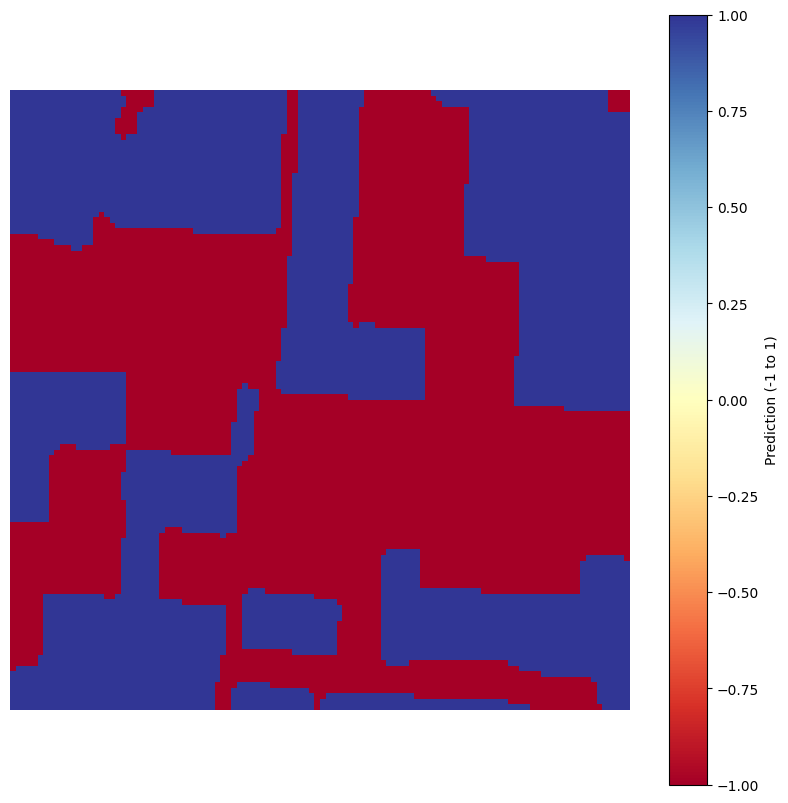

In [46]:
plot_binary_prediction(preds[5])

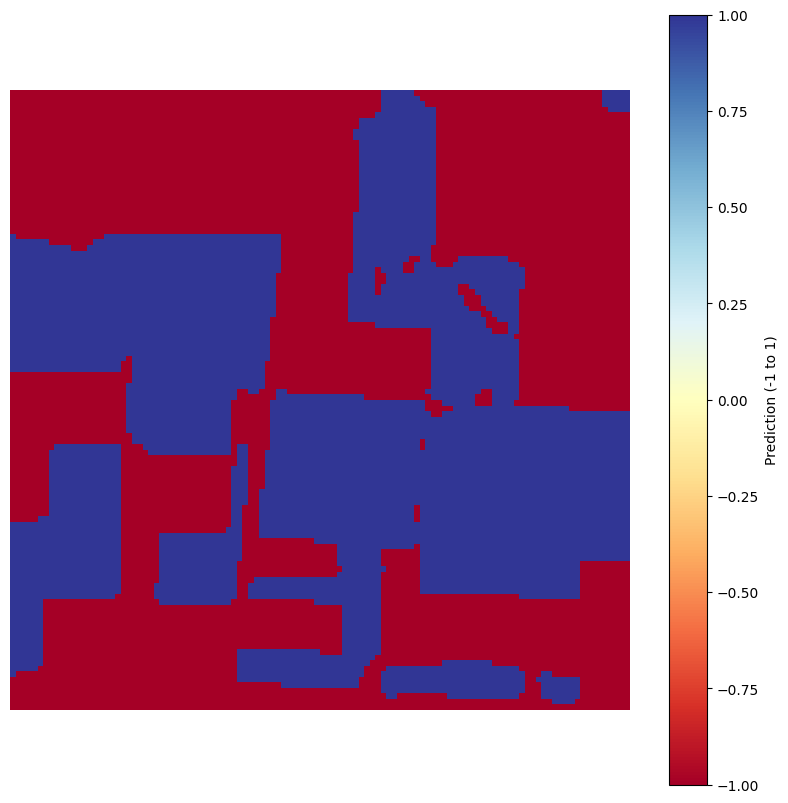

In [49]:
plot_binary_prediction(preds[1])

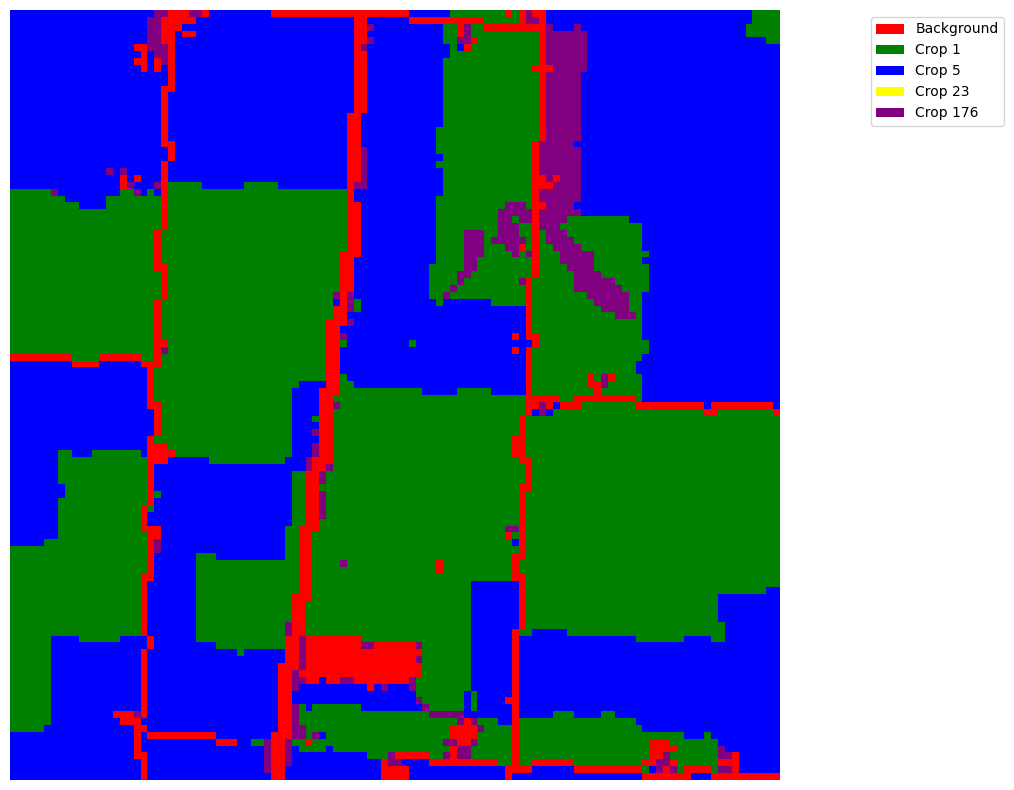

In [12]:
plot_ground_truth(quadrant_label)

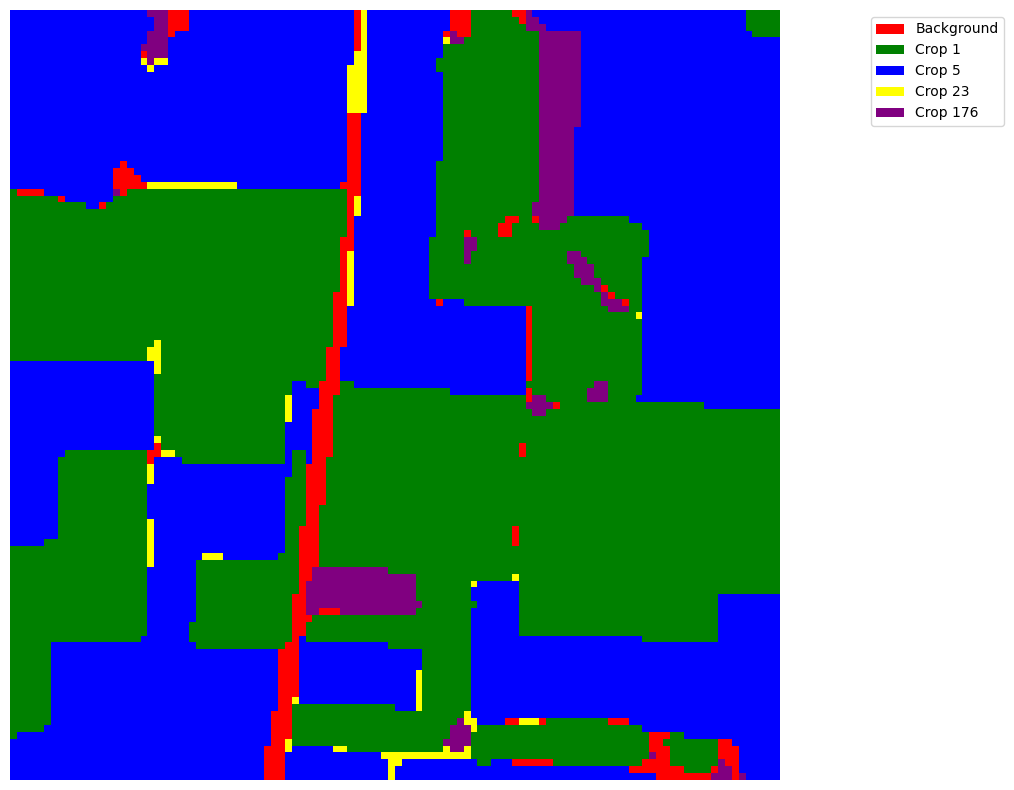

In [13]:
plot_ground_truth(quadrant_pred)

In [37]:
import torch
torch.unique(label, return_counts=True)

(tensor([ -1,   1,   5, 176], dtype=torch.int16),
 tensor([ 920, 6051, 7496,  417]))

In [1]:
import torch

In [2]:
# Load the model
loaded_model = torch.load('checkpoints/crop23_vs_all.pth')
loaded_model.eval()  # Set to evaluation mode if you're using it for inference

/tmp/ipykernel_1452603/3078881772.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('checkpoints/crop23_vs_all.pth')


FeatureExtractor(
  (cnn): ShallowCNN(
    (block_in): Sequential(
      (0): Conv2d(18, 18, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): ReLU()
    )
    (blocks_internal): ModuleList(
      (0-4): 5 x Sequential(
        (0): Conv2d(18, 18, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): ReLU()
        (2): Conv2d(18, 18, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (3): ReLU()
      )
    )
    (block_out): Sequential(
      (0): Conv2d(18, 18, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): ReLU()
    )
  )
)

In [2]:
from sklearn.metrics import f1_score

# Ground truth (true labels)
y_true = [0, 0, 0, 0, 0, 0, 0]

# Predicted labels
y_pred = [0, 0, 0, 0, 0, 0, 0]

# Compute F1-score
f1 = f1_score(y_true, y_pred, labels=[0,1], zero_division=)

print("F1 Score:", f1)


F1 Score: 0.0


/home/parham/anaconda3/envs/internship/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import numpy as np

np.unique(np.load('./binary_classifiers_outputs_deprecated/val_labels.npy'))

array([0., 1., 2., 3., 4.])